<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C3/C3.html"><img src="../data/C3_nav.png" width="100"  style="float:right;" alt="C3"></a>
<div><h1>Application: Tempo Curves</h1> </div>
</div>

<p>
Following Section 3.3.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we discuss in this notebook how synchronization results can be used for automatically computing the local tempo over time of an expressive music recordings.

<ul>  

<li><span style="color:black">
Meinard Müller, Verena Konz, Andi Scharfstein, Sebastian Ewert, and Michael Clausen:  <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2009_MuellerKonzScharfsteinEwertClausen_TempoCurves_ISMIR.pdf"><strong>Towards Automated Extraction of Tempo Parameters from Expressive Music Recordings.</strong></a>  Proceedings of the International Society for Music Information Retrieval Conference (ISMIR): 69–74, 2009. 
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_MuellerKSEC09_TempoParametersFromRecordings_ISMIR.txt"> Bibtex </a>
</span></li>
    
</ul>          
</p> 

## Performance Analysis

Musicians give a piece of music their personal touch by continuously varying tempo, dynamics, and articulation. Instead of playing mechanically, they speed up at some places and slow down at others in order to shape a piece of music. Similarly, they continuously change the sound intensity and stress certain notes. Such performance aspects are of fundamental importance for the understanding and perception of music. The automated analysis of different interpretations, also referred to as **performance analysis**, is an active field of research. Generally speaking, one may distinguish between two complementary goals. The first goal is to find commonalities between different interpretations, which allow for the derivation of general performance rules. For example, such a rule could be that most musicians tend to gradually slow down towards the end of a piece of music, thus closing off the composition. A second, even harder goal is to capture what exactly is characteristic for the style of a particular interpreter. For example, what makes Karajan so special? And how do his performances differ from recordings by other conductors?

Before analyzing a specific performance, one requires the information about when and how the notes of the underlying piece of music are actually played. Therefore, as the first step of performance analysis, one has to annotate the performance by means of suitable attributes that make the exact timing and intensity of the various note events explicit. The extraction of such performance attributes from audio recordings constitutes a challenging problem. Many researchers manually annotate the audio material by marking salient data points in the audio stream. However, being very labor-intensive, such a manual process is prohibitive in view of large audio collections.

## Tempo Curve Computation: Basic Idea

We now present an approach for deriving tempo-related information using [music synchronization](../C3/C3_MusicSynchronization.html) techniques. Many pieces from the Western classical music literature are based on a musical score. The basic idea is to use this score as a reference version (where beat positions are assumed to be known) against which the performed version can be compared. The overall procedure works as follows:

* First, the **reference version** is converted into a piano-roll presentation, where the notes are played with a known constant tempo in a purely mechanical way. 

* Then, music synchronization techniques are used to temporally align the note and beat events of the reference with their corresponding physical occurrences in a given performed audio version.

* The resulting warping path reveals the **relative tempo differences** between the actual performance and the neutral reference version. Knowing the absolute tempo of the reference version, one can then derive the tempo of the performed version at a certain position from the slope of the warping path.

More precisely, to derive a tempo value one needs to "observe" the performed version over a certain period of time. To this end, we fix a suitable time window (e.g., one beat interval). From the warping path one can read off the corresponding physical duration (given in seconds) of the performed version. From this, one can derive an average tempo value specified in [**beats per minute**](../C6/C6S2_TempoBeat.html) (BPM) for the time window. In the following code cell, we illustrate the procedure schematically using a toy example. We fix a window on the reference time axis having a duration of one beat. In the example, the first beat of the reference version is aligned to a section of the performed version lasting two seconds. In other words, the performed version has in this section an average tempo of one beat every two seconds, resulting in $30~\mathrm{BPM}$. Similarly, the second beat lasts one second corresponding to $60~\mathrm{BPM}$, the third beat lasts $0.4$ seconds corresponding to $150~\mathrm{BPM}$, and the fourth and fifth beats last $0.3$ seconds corresponding to $200~\mathrm{BPM}$. This yields a **tempo curve** for the performed version specified for each beat interval of the reference version.

<!--<img src="../data/C3/FMP_C3_F23.png" width="500px" align="center" alt="C1">-->

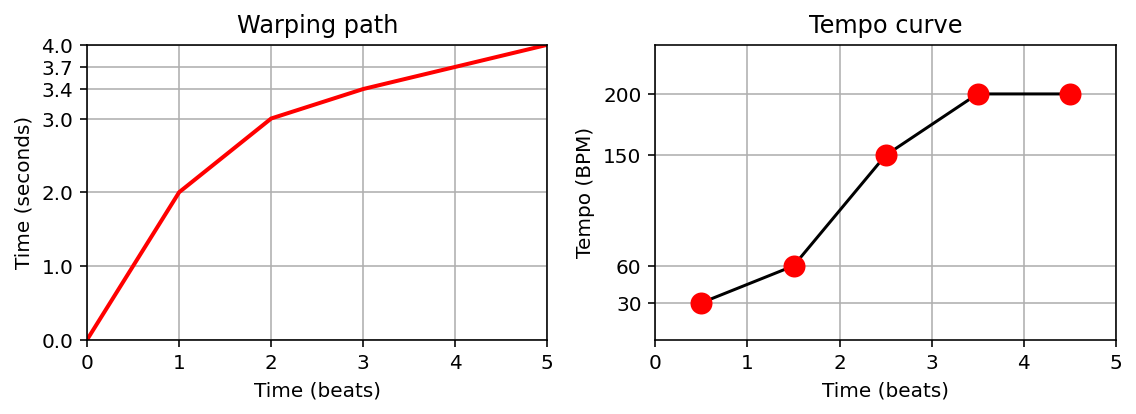

In [3]:
import os
import sys
import copy

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
import librosa
import pandas as pd
from scipy import signal
from scipy.interpolate import interp1d
import scipy.ndimage.filters
%matplotlib inline

sys.path.append('..')
import libfmp.b
import libfmp.c1
import libfmp.c3

P = np.array([[0, 0], [2, 1], [3, 2], [3.4, 3], [3.7, 4], [4, 5]])
bpm = []

pos_audio1, pos_score1 = P[0, :]
for pos_audio2, pos_score2  in P[1:]:
    dur_audio = pos_audio2 - pos_audio1
    dur_score = pos_score2 - pos_score1
    bpm.append(60 * (dur_score / dur_audio))
    pos_audio1, pos_score1 = pos_audio2, pos_score2

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].plot(P[:, 1], P[:, 0], 'r-', linewidth=2)
ax[0].set_yticks([0, 1, 2, 3.0, 3.4, 3.7, 4.0])
ax[0].grid()
ax[0].set_xlim([0, 5])
ax[0].set_ylim([0, 4])
ax[0].set_xlabel('Time (beats)')
ax[0].set_ylabel('Time (seconds)')
ax[0].set_title('Warping path')

ax[1].plot(np.arange(len(bpm)) + 0.5, bpm, 'k-')
ax[1].plot(np.arange(len(bpm)) + 0.5, bpm, 'ro', markersize=10)
ax[1].set_yticks([30, 60, 150, 200])
ax[1].grid()
ax[1].set_xlim([0, 5])
ax[1].set_ylim([0, 240])
ax[1].set_xlabel('Time (beats)')
ax[1].set_ylabel('Tempo (BPM)')
ax[1].set_title('Tempo curve')
plt.tight_layout()

## Example: Schumann's Träumerei

As an example, we consider three performances of the first eight measures of the "Träumerei" by Robert Schumann. The figure below shows the resulting tempo curves. Despite the significant differences in the overall tempo, there are also noticeable similarities in the relative shaping of the curves. For example, at the beginning of the second measure (region marked by the rectangular frame), all three pianists slow down. The musical reason is that there is a climax of the ascending melodic line in the first measure culminating in the marked subdominant chord (in $\mathrm{B}$ major). This climax is further highlighted by a preceding ritardando. After the climax, the tension is released, and one can notice a considerable speed up in all three performances to return to the original tempo. As mentioned before, deriving such general rules is one of the goals of performance analysis.

<img src="../data/C3/FMP_C3_F24.png" width="500px" align="center" alt="C1">

The tempo curves as shown in the figure were computed using high-resolution music synchronization techniques in combination with adaptive windowing techniques. Details can be found in the paper 
<a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2009_MuellerKonzScharfsteinEwertClausen_TempoCurves_ISMIR.pdf"><strong>Towards Automated Extraction of Tempo Parameters from Expressive Music Recordings</strong></a>. In the following, we only introduce the main ideas, using standard chroma-based features in combination with basic DTW techniques. The quality of resulting tempo curves, as we will see, crucially depend on numerous parameter settings.

As our running example throughout this notebook, we use the first 34 beats of Robert Schumann's Träumerei. This excerpt consists of the upbeat, the first eight measures, plus one more beat (the F of the repetition).

## Computation: Chromagram 

Following the approach as described, we now describe a baseline implementation for computing tempo curve. We assume that the score-based reference version is given in form of a [CSV file](../C1/C1S2_CSV.html) containing the start times (give in beats), pitches (given as MIDI note numbers), and durations (given in beats) of the individual note events. In the following code cell, we convert the reference version (shown as [piano roll representation](../C1/C1S2_PianoRoll.html)) into a [chromagram](../C3/C3S1_SpecLogFreq-Chromagram.html) as follows:

* First, we specify a sampling rate (`Fs_beat`) that defines the number of frames per beat. 
* Then, the piano-roll representation is converted into a chroma representation by summing up the pitch bands that correspond to the same chroma. 
* The resulting chroma features are normalized with respect to the $\ell^2$-norm. 

In the following, we use `Fs_beat=10` which results in $10$ feature vectors per beat. Having $34$ beats in our running example, this results in feature sequence of length $340$. Note that, when thinking of a performance, this length corresponds to a constant tempo of $60~\mathrm{BPM}$ using a feature rate of $10$ frames per second. 

Similarly, we convert the audio recording of a given performance into [chromagram](../C3/C3S1_SpecLogFreq-Chromagram.html), where the chroma vectors are again normalized with respect to the $\ell^2$-norm. In the following, we use a feature rate of $10~\mathrm{Hz}$. In the subsequent example, we use a piano recording of the first $34$ beats performed by Gabriel Antonio Hernandez Romero. 

<audio src="../data/C3/FMP_C3S3_Schumann_Op15No7_Traeumerei_HernandezRomero.mp3" type="audio/mpeg" controls="controls"> </audio> 

First six note events of score CVS file:
   Start  Duration  Pitch  Velocity  Instrument
0    0.0       1.0   60.0   0.70866         NaN
1    1.0       1.0   41.0   0.70866         NaN
2    1.0       4.0   41.0   0.70866         NaN
3    1.0       2.0   65.0   0.70866         NaN
4    2.0       3.0   48.0   0.70866         NaN
5    2.0       3.0   53.0   0.70866         NaN


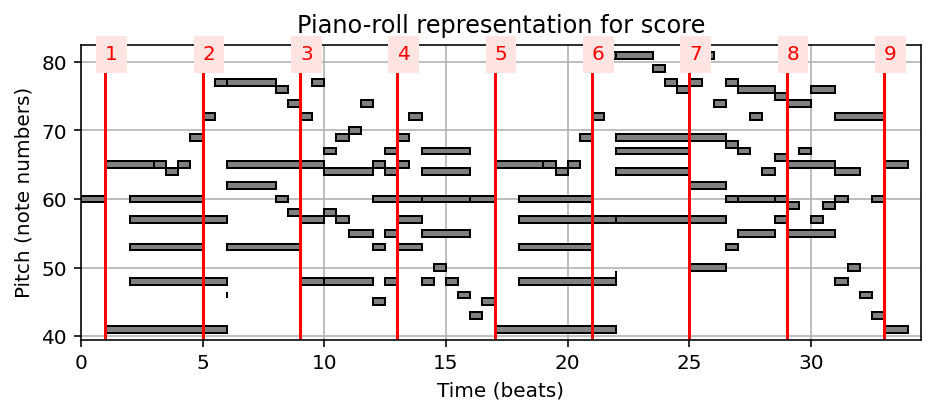

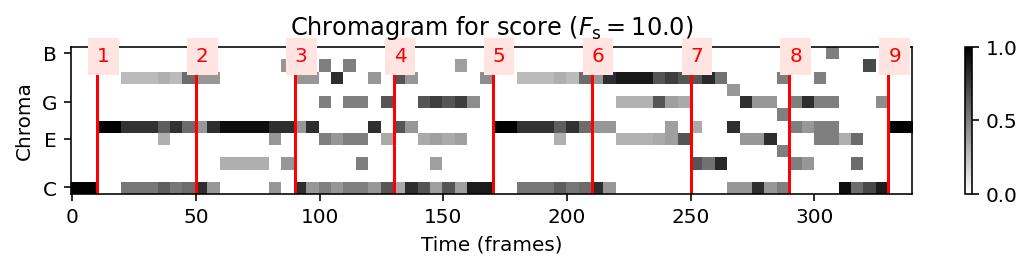

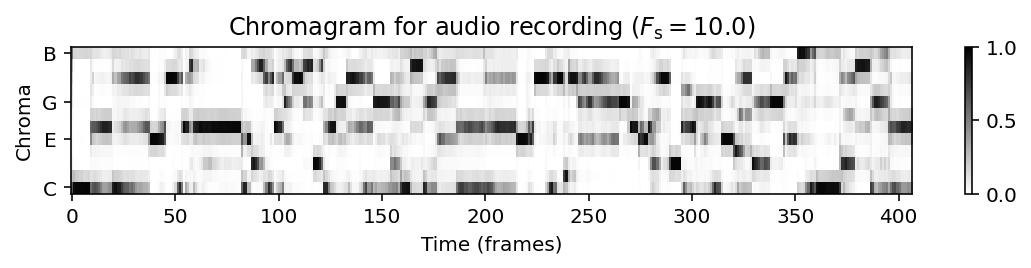

In [4]:
def compute_score_chromagram(score, Fs_beat):
    """Compute chromagram from score representation

    Notebook: C3/C3S3_MusicAppTempoCurve.ipynb

    Args:
        score (list): Score representation
        Fs_beat (scalar): Sampling rate for beat axis

    Returns:
        X_score (np.ndarray): Chromagram representation X_score
        t_beat (np.ndarray): Time axis t_beat (given in beats)
    """
    score_beat_min = min(n[0] for n in score)
    score_beat_max = max(n[0] + n[1] for n in score)
    beat_res = 1.0 / Fs_beat
    t_beat = np.arange(score_beat_min, score_beat_max, beat_res)
    X_score = np.zeros((12, len(t_beat)))

    for start, duration, pitch, velocity, label in score:
        start_idx = int(round(start / beat_res))
        end_idx = int(round((start + duration) / beat_res))
        cur_chroma = int(round(pitch)) % 12
        X_score[cur_chroma, start_idx:end_idx] += velocity

    X_score = librosa.util.normalize(X_score, norm=2)
    return X_score, t_beat

def plot_measure(ax, measure_pos):
    """Plot measure positions

    Notebook: C3/C3S3_MusicAppTempoCurve.ipynb

    Args:
        ax (mpl.axes.Axes): Figure axis
        measure_pos (list or np.ndarray): Array containing measure positions
    """
    y_min, y_max = ax.get_ylim()
    ax.vlines(measure_pos, y_min, y_max, color='r')
    for m in range(len(measure_pos)):
        ax.text(measure_pos[m], y_max, '%s' % (m + 1),
                color='r', backgroundcolor='mistyrose',
                verticalalignment='top', horizontalalignment='left')
    
# Read score file and plot piano-roll representation
fn_score = os.path.join('..', 'data', 'C3', 'FMP_C3S3_Schumann_Op15No7_Traeumerei_MusicXML.csv')
measure_pos_beat = np.array([1, 5, 9, 13, 17, 21, 25, 29, 33])
df = pd.read_csv(fn_score, sep=';')
print('First six note events of score CVS file:')
print(df.loc[0:5, :])

score = libfmp.c1.csv_to_list(fn_score)
fig, ax = libfmp.c1.visualize_piano_roll(score, xlabel='Time (beats)', 
                                         ylabel='Pitch (note numbers)', 
                                         colors=['gray'], 
                                         velocity_alpha=False, figsize=(6.6, 3))
ax.set_title('Piano-roll representation for score')
ax.get_legend().remove()
plot_measure(ax, measure_pos_beat)
plt.tight_layout()

 # Compute and plot score-based chromagram
Fs_beat = 10
X_score, t_beat = compute_score_chromagram(score, Fs_beat)
figsize = (8, 2)
fig, ax, im = libfmp.b.plot_chromagram(X_score, Fs=1, figsize=figsize, 
                                       xlabel='Time (frames)', 
                                       title='Chromagram for score ($F_\mathrm{s} = %.1f$)'%Fs_beat,
                                       chroma_yticks=[0, 4, 7, 11])
plot_measure(ax[0], measure_pos_beat * Fs_beat)
plt.tight_layout()

# Read signal 
Fs = 22050
#fn_wav = os.path.join('..', 'data', 'C3', 'FMP_C3S3_Schumann_Op15No7_Traeumerei_Zbinden.wav')
fn_wav = os.path.join('..', 'data', 'C3', 'FMP_C3S3_Schumann_Op15No7_Traeumerei_HernandezRomero.wav')
x, Fs = librosa.load(fn_wav, Fs)

# Compute and plot chromagram
N = 4410
H = 2205
Fs_X = Fs / 2205
X = librosa.feature.chroma_stft(y=x, sr=Fs, norm=2, tuning=0, hop_length=H, n_fft=N)
libfmp.b.plot_chromagram(X, figsize=figsize, xlabel='Time (frames)', clim=[0, 1],
                         title='Chromagram for audio recording ($F_\mathrm{s} = %.1f$)'%Fs_X, 
                         chroma_yticks=[0, 4, 7, 11])
plt.tight_layout()

## Computation: Alignment Path

Based on the chromagrams, we apply [dynamic time warping](../C3/C3S2_DTWbasic.html) (DTW) for synchronizing the audio version to the score-based reference version. In the following code cell, we apply a basic DTW procedure for computing a cost matrix $C$, an accumulated cost matrix $D$, and an optimal warping path $P$.

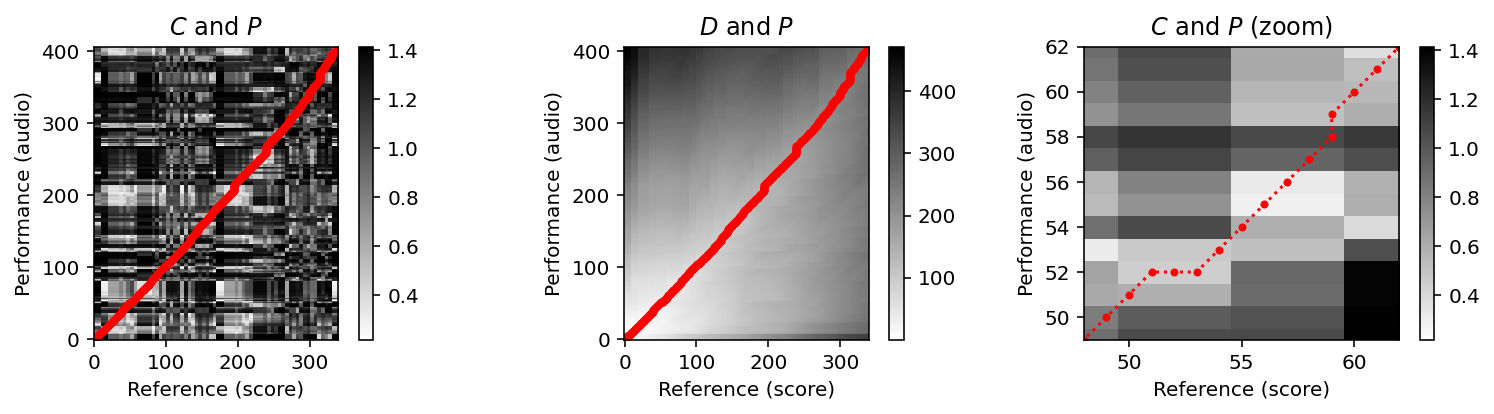

In [5]:
# Compute DTW and plot C, D, P
C = libfmp.c3.compute_cost_matrix(X, X_score, metric='euclidean')
sigma = np.array([[1, 0], [0, 1], [1, 1]])
D, P = librosa.sequence.dtw(C=C, step_sizes_sigma=sigma)
P = P[::-1, :]  # reverse P

fig, ax = plt.subplots(1, 3, figsize=(11, 3))    
libfmp.c3.plot_matrix_with_points(C, P, linestyle=':', marker='.', ax=[ax[0]],  
                                  ylabel='Performance (audio)', xlabel='Reference (score)',
                                  title='$C$ and $P$', aspect='equal')
libfmp.c3.plot_matrix_with_points(D, P, linestyle=':', marker='.', ax=[ax[1]],  
                                  ylabel='Performance (audio)', xlabel='Reference (score)',
                                  title='$D$ and $P$', aspect='equal')
libfmp.c3.plot_matrix_with_points(C, P, linestyle=':', marker='.', ax=[ax[2]],  
                                  ylabel='Performance (audio)', xlabel='Reference (score)',
                                  title='$C$ and $P$ (zoom)', aspect='equal')
zoom_beat = np.array([4.8, 6.2])
zoom_sec = np.array([4.9, 6.2])
ax[2].set_xlim(zoom_beat * Fs_beat)
ax[2].set_ylim(zoom_sec * Fs_X)
plt.tight_layout()

To compute relative tempo differences, one basically needs to derive the slope of the warping path and then take its reciprocal to derive the tempo. This, however, becomes problematic when the warping path runs horizontally (slope is zero) or vertically (slope is infinite). We remove such degenerations by deleting all horizontal and vertical sections. As a result, we obtain a modified path that is **strictly monotonous** in both dimension. We call this path a **strict alignment path**. Note that  this path no longer fulfills the step-size conditions. 

In the following code cell, we provide two alternative implementations (yielding the same result) for converting a warping path into a strict alignment path. In this construction, we enforce that the [**boundary condition**](../C3/C3S2_DTWbasic.html) is still valid (i.e., the resulting path starts and ends with the same cells $(1,1)$ and $(N,M)$ as the original warping path). We will illustrate the effect by means of a small toy example, and then continue with our Schumann example.

Toy example:


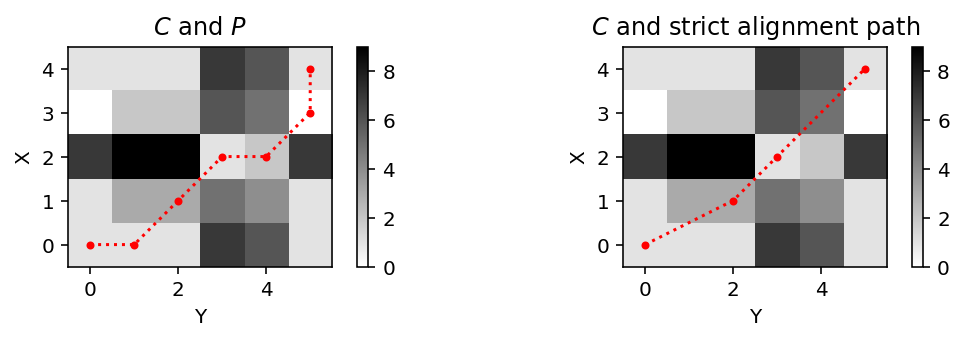

Schumann example (zoom):


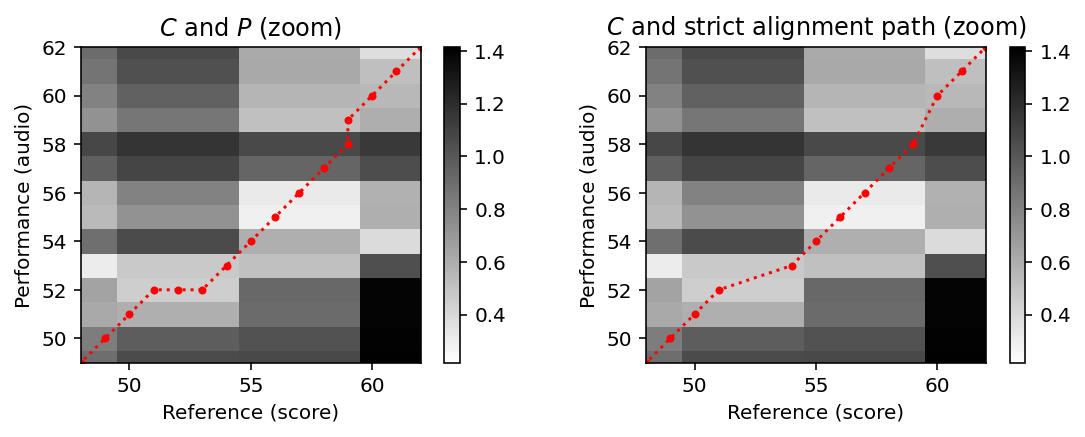

In [6]:
def compute_strict_alignment_path(P):
    """Compute strict alignment path from a warping path

    Notebook: C3/C3S3_MusicAppTempoCurve.ipynb

    Args:
        P (list or np.ndarray): Warping path

    Returns:
        P_mod (list or np.ndarray): Strict alignment path
    """
    # Initialize P_mod and enforce start boundary condition
    P_mod = np.zeros(P.shape)
    P_mod[0] = P[0]
    N, M = P[-1]
    # Go through all cells of P until reaching last row or column
    assert N > 1 and M > 1, 'Length of sequences must be longer than one.'
    i, j = 0, 0
    n1, m1 = P[i]
    while True:
        i += 1
        n2, m2 = P[i]
        if n2 == N or m2 == M:
            # If last row or column is reached, quit loop
            break
        if n2 > n1 and m2 > m1:
            # Strict monotonicity condition is fulfuilled
            j += 1
            P_mod[j] = n2, m2
            n1, m1 = n2, m2
    j += 1
    # Enforce end boundary condition
    P_mod[j] = P[-1]
    P_mod = P_mod[:j+1]
    return P_mod

def compute_strict_alignment_path_mask(P):
    """Compute strict alignment path from a warping path

    Notebook: C3/C3S3_MusicAppTempoCurve.ipynb

    Args:
        P (list or np.ndarray): Wapring path

    Returns:
        P_mod (list or np.ndarray): Strict alignment path
    """
    P = np.array(P, copy=True)
    N, M = P[-1]
    # Get indices for strict monotonicity
    keep_mask = (P[1:, 0] > P[:-1, 0]) & (P[1:, 1] > P[:-1, 1])
    # Add first index to enforce start boundary condition
    keep_mask = np.concatenate(([True], keep_mask))
    # Remove all indices for of last row or column
    keep_mask[(P[:, 0] == N) | (P[:, 1] == M)] = False
    # Add last index to enforce end boundary condition
    keep_mask[-1] = True
    P_mod = P[keep_mask, :]

    return P_mod

# Small toy example for testing
print('Toy example:')
X_toy =  [1, 3, 9, 2, 1]
Y_toy = [2, 0, 0, 8, 7, 2]
C_toy = libfmp.c3.compute_cost_matrix(X_toy, Y_toy, metric='euclidean')
sigma = np.array([[1, 0], [0, 1], [1, 1]])
D_toy, P_toy = librosa.sequence.dtw(C=C_toy, step_sizes_sigma=sigma)
P_toy = P_toy[::-1, :]  # reverse P
P_toy_mod =  compute_strict_alignment_path(P_toy)

fig, ax = plt.subplots(1, 2, figsize=(8, 2.5))    
libfmp.c3.plot_matrix_with_points(C_toy, P_toy, linestyle=':', marker='.', ax=[ax[0]],  
                                  ylabel='X', xlabel='Y',
                                  title='$C$ and $P$', aspect='equal')

libfmp.c3.plot_matrix_with_points(C_toy, P_toy_mod, linestyle=':', marker='.', ax=[ax[1]],  
                                  ylabel='X', xlabel='Y',
                                  title='$C$ and strict alignment path', aspect='equal')
plt.tight_layout()
plt.show()

# Continuation with Schumann example
print('Schumann example (zoom):')
P_mod =  compute_strict_alignment_path(P)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))    
libfmp.c3.plot_matrix_with_points(C, P, linestyle=':', marker='.', ax=[ax[0]],  
                                  ylabel='Performance (audio)', xlabel='Reference (score)',
                                  title='$C$ and $P$ (zoom)', aspect='equal')
ax[0].set_xlim(zoom_beat * Fs_beat)
ax[0].set_ylim(zoom_sec * Fs_X)

libfmp.c3.plot_matrix_with_points(C, P_mod, linestyle=':', marker='.', ax=[ax[1]],  
                                  ylabel='Performance (audio)', xlabel='Reference (score)',
                                  title='$C$ and strict alignment path (zoom)', aspect='equal')
ax[1].set_xlim(zoom_beat * Fs_beat)
ax[1].set_ylim(zoom_sec * Fs_X)
plt.tight_layout()
plt.show()

## Computation: Tempo Curve

The strict alignment path can be regarded as a strictly increasing function from the reference axis (given in beats) to the time axis of the performance (given in seconds). Intuitively speaking, the derivative of this function can be regarded as **beat&ndash;duration function**, which specifies for each beat position the performance duration given in **seconds per beat** (SPB). This function can be further processed by applying smoothing operations. For example, one may apply an averaging filter of a certain length (specified in beats) to indicate the moving average duration over the given window. To realize this idea, we use in the following implementation the following techniques:

* We interpret the strict alignment path as a function from beat to time (function `f_path_sec`)
* To fill the gaps, we use linear interpolation techniques (reference time line `t_beat`)
* We then compute a frame-wise difference to obtain a beat&ndash;duration representation.
* We apply a normalized Hann window for smoothing this representation (length `win_len_beat`)

In the following code cell, these steps are implemented and plotted for our Schumann example.

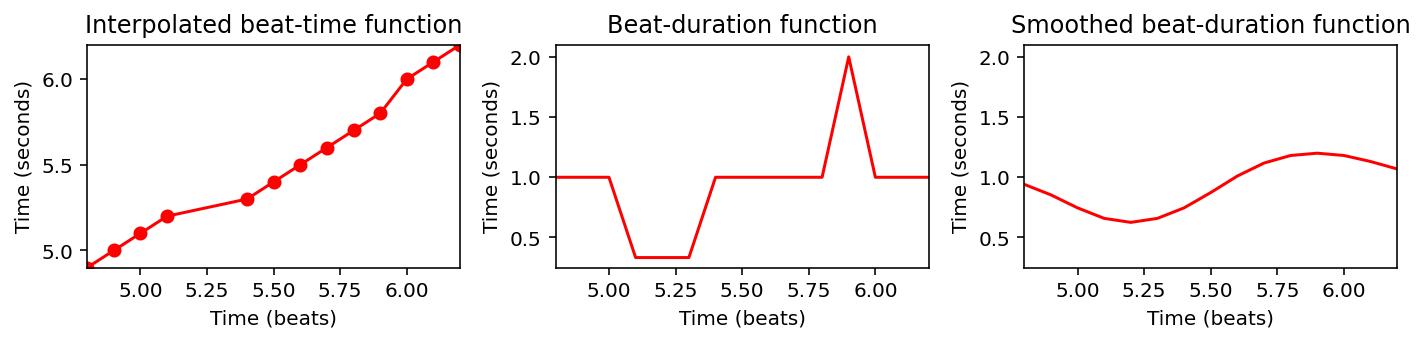

In [7]:
# Convert path into beat-time function and interpolte 
t_path_beat = P_mod[:, 1] / Fs_beat
f_path_sec = P_mod[:, 0] / Fs_X
f_sec = interp1d(t_path_beat, f_path_sec, kind='linear', fill_value='extrapolate')(t_beat)

# Compute difference and smooth with Hann window
f_diff_sec = np.diff(f_sec) * Fs_beat
f_diff_sec = np.concatenate((f_diff_sec, np.array([0])))
win_len_beat = 1
filt_len = int(win_len_beat * Fs_beat * 1.1)
filt_win = signal.hann(filt_len)
filt_win = filt_win / np.sum(filt_win)
f_diff_smooth_sec = scipy.ndimage.filters.convolve(f_diff_sec, filt_win, mode='nearest')    

fig, ax = plt.subplots(1, 3, figsize=(10, 2.5)) 
ax[0].plot(t_beat, f_sec, 'r')
ax[0].plot(t_path_beat, f_path_sec, color='r',  marker='o', linestyle='')
ax[0].set_title('Interpolated beat-time function')
ax[0].set_xlim(zoom_beat)
ax[0].set_ylim(zoom_sec)
ax[0].set_xlabel('Time (beats)')
ax[0].set_ylabel('Time (seconds)')

ax[1].plot(t_beat, f_diff_sec, 'r')
ax[1].set_title('Beat-duration function')
ax[1].set_xlim(zoom_beat)
ax[1].set_ylim([0.25, 2.1])
ax[1].set_xlabel('Time (beats)')
ax[1].set_ylabel('Time (seconds)')

ax[2].plot(t_beat, f_diff_smooth_sec, 'r')
ax[2].set_title('Smoothed beat-duration function')
ax[2].set_xlim(zoom_beat)
ax[2].set_ylim([0.25, 2.1])
ax[2].set_xlabel('Time (beats)')
ax[2].set_ylabel('Time (seconds)')
plt.tight_layout()

From the **beat&ndash;duration function**, it is straightforward to obtain a **beat&ndash;tempo function**. To this end, one needs to take the reciprocal of the duration values multiplied with $60$ (to get beats per minute). This function yields what we simply refer to as **tempo curve**. Note that plotting a tempo curve using a linearly spaced BPM-axis leads to an overemphasis of higher tempo values compared to lower tempo values. In the following code cell, we provide a plotting function with a logarithmically spaced BPM-axis.

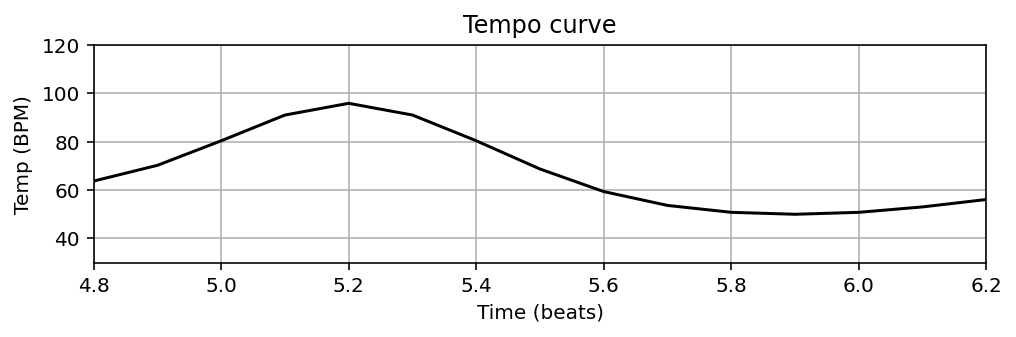

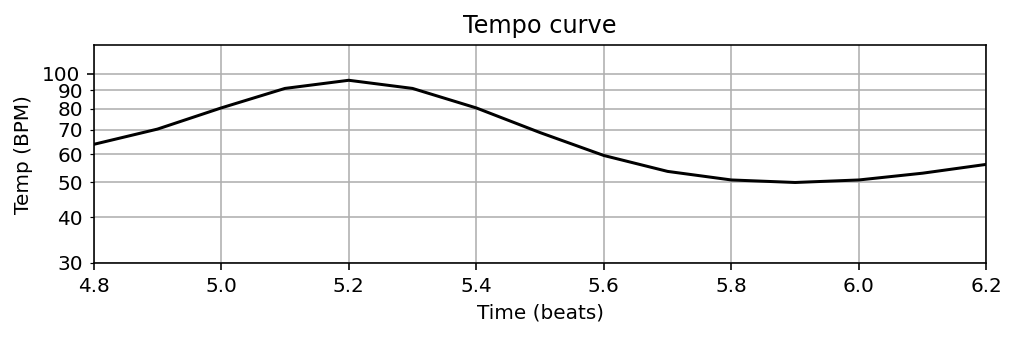

In [8]:
def plot_tempo_curve(f_tempo, t_beat, ax=None, figsize=(8, 2), color='k', logscale=False,
                     xlabel='Time (beats)', ylabel='Temp (BPM)', xlim=None, ylim=None,
                     label='', measure_pos=[]):
    """Plot a tempo curve

    Notebook: C3/C3S3_MusicAppTempoCurve.ipynb

    Args:
        f_tempo: Tempo curve
        t_beat: Time axis of tempo curve (given as sampled beat axis)
        ax: Plot either as figure (ax==None) or into axis (ax==True) (Default value = None)
        figsize: Size of figure (Default value = (8, 2))
        color: Color of tempo curve (Default value = 'k')
        logscale: Use linear (logscale==False) or logartihmic (logscale==True) tempo axis (Default value = False)
        xlabel: Label for x-axis (Default value = 'Time (beats)')
        ylabel: Label for y-axis (Default value = 'Temp (BPM)')
        xlim: Limits for x-axis (Default value = None)
        ylim: Limits for x-axis (Default value = None)
        label: Figure labels when plotting into axis (ax==True) (Default value = '')
        measure_pos: Plot measure positions as spefified (Default value = [])

    Returns:
        fig: figure handle
        ax: axes handle
    """
    fig = None
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = plt.subplot(1, 1, 1)
    ax.plot(t_beat, f_tempo, color=color, label=label)
    ax.set_title('Tempo curve')
    if xlim is None:
        xlim = [t_beat[0], t_beat[-1]]
    if ylim is None:
        ylim = [np.min(f_tempo) * 0.9, np.max(f_tempo) * 1.1]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, which='both')
    if logscale:
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.yaxis.set_minor_formatter(ScalarFormatter())
        # ax.set_yticks([], minor=True)
        # yticks = np.arange(ylim[0], ylim[1]+1, 10)
        # ax.set_yticks(yticks)
    plot_measure(ax, measure_pos)
    return fig, ax

f_tempo = 1. / f_diff_smooth_sec * 60
plot_tempo_curve(f_tempo, t_beat, xlim=zoom_beat, ylim=[30, 120])
plot_tempo_curve(f_tempo, t_beat, xlim=zoom_beat, ylim=[30, 120], logscale=True);

## Computation: Overall Procedure

We now define the function `compute_tempo_curve`, which summarizes the overall procedure described before. We apply this procedure to the Schumann example, considering the first $34$ beats of the score and a corresponding excerpt of the piano recording by Gabriel Antonio Hernandez Romero. The dependencies of the final result and the various parameters are discussed below. 

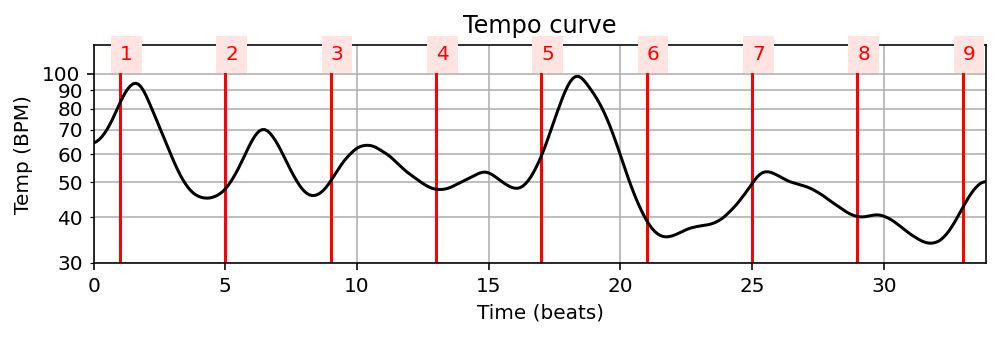

In [9]:
def compute_tempo_curve(score, x, Fs=22050, Fs_beat=10, N=4410, H=2205, shift=0,
                        sigma=np.array([[1, 0], [0, 1], [2, 1], [1, 2], [1, 1]]),
                        win_len_beat=4):
    """Compute a tempo curve

    Notebook: C3/C3S3_MusicAppTempoCurve.ipynb

    Args:
        score (list): Score representation
        x (np.ndarray): Audio signal
        Fs (scalar): Samping rate of audio signal (Default value = 22050)
        Fs_beat (scalar): Sampling rate for beat axis (Default value = 10)
        N (int): Window size for computing audio chromagram (Default value = 4410)
        H (int): Hop size for computing audio chromagram (Default value = 2205)
        shift (int): Cyclic chroma shift applied to audio chromagram (Default value = 0)
        sigma (np.ndarray): Step size set used for DTW
            (Default value = np.array([[1, 0], [0, 1], [2, 1], [1, 2], [1, 1]]))
        win_len_beat (float): Window length (given in beats) used for smoothing tempo curve (Default value = 4)

    Returns:
        f_tempo (np.ndarray): Tempo curve
        t_beat (np.ndarray): Time axis (given in beats)
    """

    # Compute score an audio chromagram
    X_score, t_beat = compute_score_chromagram(score, Fs_beat)
    Fs_X = Fs / H
    X = librosa.feature.chroma_stft(y=x, sr=Fs, norm=2, tuning=0, hop_length=H, n_fft=N)
    X = np.roll(X, shift, axis=0)

    # Apply DTW to compte C, D, P
    C = libfmp.c3.compute_cost_matrix(X, X_score, metric='euclidean')
    D, P = librosa.sequence.dtw(C=C, step_sizes_sigma=sigma)
    P = P[::-1, :]  # reverse P
    P_mod = compute_strict_alignment_path(P)

    # Convert path into beat-time function and interpolte
    t_path_beat = P_mod[:, 1] / Fs_beat
    f_path_sec = P_mod[:, 0] / Fs_X
    f_sec = interp1d(t_path_beat, f_path_sec, kind='linear', fill_value='extrapolate')(t_beat)

    # Compute difference and smooth with Hann window
    f_diff_sec = np.diff(f_sec) * Fs_beat
    pad = np.array([f_diff_sec[-1]])
    f_diff_sec = np.concatenate((f_diff_sec, pad))
    # f_diff_sec = np.concatenate((f_diff_sec, np.array([0]) ))
    filt_len = int(win_len_beat * Fs_beat)
    filt_win = signal.hann(filt_len)
    filt_win = filt_win / np.sum(filt_win)
    f_diff_smooth_sec = scipy.ndimage.filters.convolve(f_diff_sec, filt_win, mode='reflect')

    # Compute tempo curve
    f_tempo = 1. / f_diff_smooth_sec * 60

    return f_tempo, t_beat

# Read score
fn_score = os.path.join('..', 'data', 'C3', 'FMP_C3S3_Schumann_Op15No7_Traeumerei_MusicXML.csv')
score = libfmp.c1.csv_to_list(fn_score)
measure_pos_beat = np.array([1, 5, 9, 13, 17, 21, 25, 29, 33])

# Read wav
Fs = 22050
fn_wav = os.path.join('..', 'data', 'C3', 'FMP_C3S3_Schumann_Op15No7_Traeumerei_HernandezRomero.wav')
x, Fs = librosa.load(fn_wav, Fs)

# Compute and plot tempo curve
f_tempo, t_beat = compute_tempo_curve(score, x)
ylim = [30, 120]
plot_tempo_curve(f_tempo, t_beat, logscale=True, ylim=ylim, measure_pos=measure_pos_beat);  

## Parameter: Window Length

In our procedure, there are many assumptions and parameters that have a crucial influence on the quality of the resulting tempo curve. In the subsequent code cells, we have a closer look at some of these parameters. We start with the parameter `win_len_beat`, which determines the length of the Hann-weighted averaging filter (given in beats) to smooth the beat&ndash;duration function.


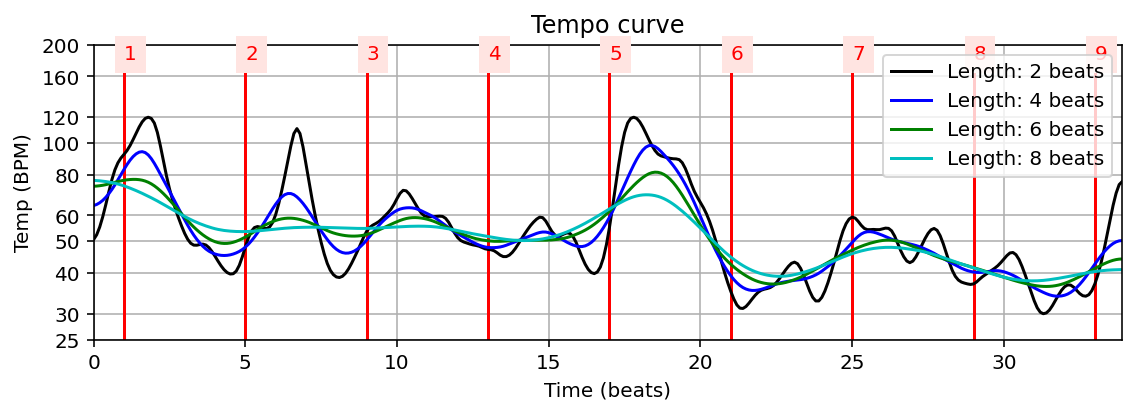

In [10]:
ylim = [25, 200]
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
plt.title('Dependency on window length')

para_dict = {}
para_dict[0] = [2, 'k']
para_dict[1] = [4, 'b']
para_dict[2] = [6, 'g']
para_dict[3] = [8, 'c']

for n in para_dict:
    win_len_beat, color = para_dict[n]
    label='Length: %d beats' % win_len_beat
    f_tempo, t_beat = compute_tempo_curve(score, x, win_len_beat=win_len_beat)
    plot_tempo_curve(f_tempo, t_beat, ax=ax, color=color, label=label,
                         logscale=True, ylim=ylim, measure_pos=measure_pos_beat)
    
ax.legend(loc='upper right')
ax.set_yticks([], minor=True)
yticks = np.array([25, 30, 40, 50, 60, 80, 100, 120, 160, 200])
ax.set_yticks(yticks)
plt.tight_layout()

## Parameter: Step-Size Condition

The quality of the warping path is decisive for the further calculation of the tempo curve. Besides the input representation (in our case, chroma-based features), the DTW results depends on parameters such as the local cost measure and the step size condition. In the following experiment, we demonstrate the effect of using different step size sets on the final tempo curve. The results have to be taken with caution, since some of the resulting warping paths show local deviations that lead to significant outliers in the tempo curves.

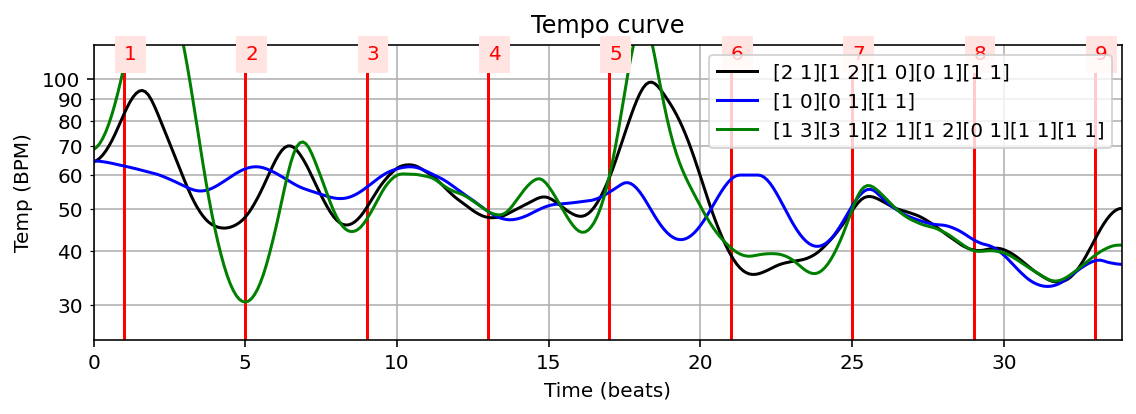

In [11]:
ylim = [25, 120]
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
plt.title('Dependency on step size condition')

para_dict = {}
para_dict[0] = [np.array([[2, 1], [1, 2], [1, 0], [0, 1], [1, 1]]), 'k']
para_dict[1] = [np.array([[1, 0], [0, 1], [1, 1]]), 'b']
para_dict[3] = [np.array([[1, 3], [3, 1], [2, 1], [1, 2], [0, 1], [1, 1], [1, 1]]), 'g']

for n in para_dict:
    sigma, color = para_dict[n]
    label = ''.join(str(s) for s in sigma)
    f_tempo, t_beat = compute_tempo_curve(score, x, sigma=sigma)
    plot_tempo_curve(f_tempo, t_beat, ax=ax, color=color, label=label,
                         logscale=True, ylim=ylim, measure_pos=measure_pos_beat)
    
ax.legend(loc='upper right')
plt.tight_layout()

## Dependency: Feature Resolution

In the previous computations, we used a sampling rate of `Fs_beat=10` for the beat-based reference axis of the score representation. This simulates a constant tempo of $60~\mathrm{BPM}$ when assuming an audio feature rate of $10$ frames per second. Similarly, using `Fs_beat=20` simulates a constant tempo of $30~\mathrm{BPM}$. Changing `Fs_beat` (while fixing the feature rate for the audio representation) may result in substantial differences in the warping path and the derived tempo curve. This dependency is illustrated by the next code cell.

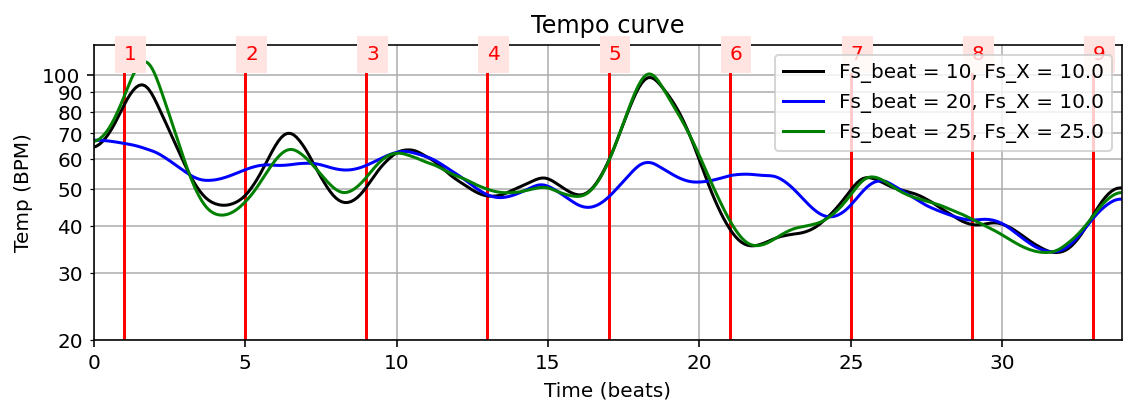

In [12]:
ylim = [20, 120]
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
plt.title('Dependency on feature resolutions')

para_dict = {}
para_dict[0] = [10, 2205, 'k']
para_dict[1] = [20, 2205, 'b']
para_dict[2] = [25, 882, 'g']

for n in para_dict:
    Fs_beat, H, color = para_dict[n]
    label='Fs_beat = %d, Fs_X = %.1f' % (Fs_beat, Fs/H)
    f_tempo, t_beat = compute_tempo_curve(score, x, Fs_beat=Fs_beat, H=H)
    plot_tempo_curve(f_tempo, t_beat, ax=ax, color=color, label=label,
                         logscale=True, ylim=ylim, measure_pos=measure_pos_beat)
ax.legend(loc='upper right')
plt.tight_layout()

## Chromagram: Audio Recordings

In the following experiments, we use four different recordings of the beginning (8 measures, 33 beats) of Robert Schumann's Träumerei. The recordings were obtained from <a href="https://imslp.org/wiki/Kinderszenen%2C_Op.15_(Schumann%2C_Robert)" target="_blank">IMSLP</a>, provided under different Creative Commons licenses. The first three recordings are piano performances, whereas the last performance is an arrangement for cello and piano. 

<table style="border:none;text-align:left;">
   <tr>
      <th style="border:none;text-align:left;">Short Name</th>
      <th style="border:none;text-align:left;">Performers</th>
      <th style="border:none;text-align:left;">Audio</th>
   </tr>

   <tr>
      <td style="border:none;text-align:left;">Romero</td>
      <td style="border:none;text-align:left;">Gabriel Antonio Hernandez Romero (piano)</td>
      <td style="border:none;text-align:left;">
         <audio src="../data/C3/FMP_C3S3_Schumann_Op15No7_Traeumerei_HernandezRomero.mp3" type="audio/mpeg" controls="controls"></audio>
      </td>
   </tr>    
    
   <tr>
      <td style="border:none;text-align:left;">Zbinden</td>
      <td style="border:none;text-align:left;">Christoph Zbinden (piano)</td>
      <td style="border:none;text-align:left;">
         <audio src="../data/C3/FMP_C3S3_Schumann_Op15No7_Traeumerei_Zbinden.mp3" type="audio/mpeg" controls="controls"></audio>
      </td>
   </tr>    
   
   <tr>
      <td style="border:none;text-align:left;">Ko</td>
      <td style="border:none;text-align:left;">Tim Ko (piano) </td>
      <td style="border:none;text-align:left;">
         <audio src="../data/C3/FMP_C3S3_Schumann_Op15No7_Traeumerei_TimKo.mp3" type="audio/mpeg" controls="controls"></audio>
      </td>
   </tr>
    
   <tr>
      <td style="border:none;text-align:left;">Colliard</td>
      <td style="border:none;text-align:left;">Matilda Colliard (cello), Stefano Ligoratti (piano) </td>
      <td style="border:none;text-align:left;">
         <audio src="../data/C3/FMP_C3S3_Schumann_Op15No7_Traeumerei_ColliardLigoratti.mp3" type="audio/mpeg" controls="controls"></audio>
      </td>
   </tr>    
   
</table>

Note that the Colliard/Ligoratti recording is [transposed](../C3/C3S1_TranspositionTuning.html) by a forth (five semitones upwards) compared to the other version. We compensate for this transposition by [cylically shifting the chromagram](../C3/C3S1_TranspositionTuning.html).

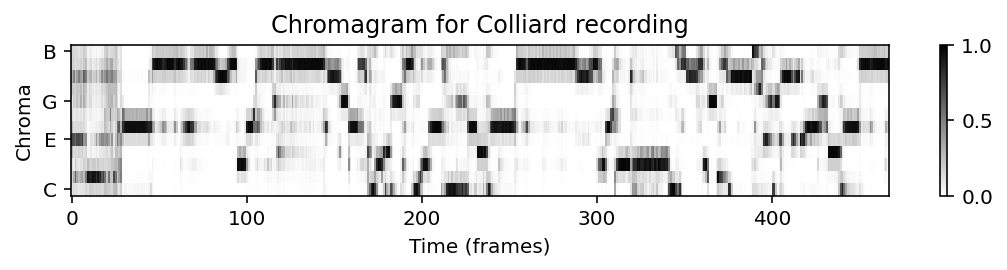

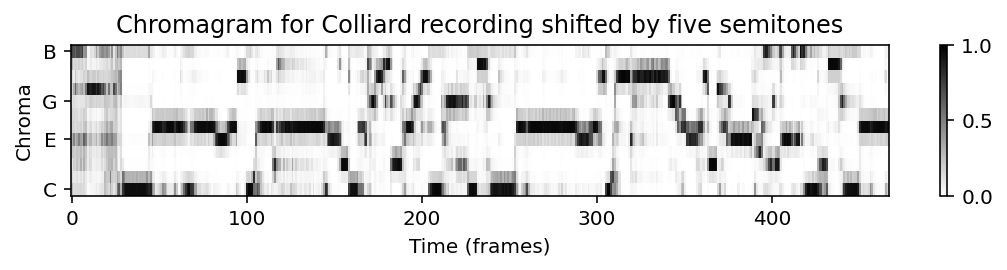

In [13]:
Fs = 22050
fn_wav = os.path.join('..', 'data', 'C3', 'FMP_C3S3_Schumann_Op15No7_Traeumerei_ColliardLigoratti.wav')
x, Fs = librosa.load(fn_wav, Fs)

# Compute and plot chromagram
N = 4410
H = 2205
Fs_X = Fs / 2205
X = librosa.feature.chroma_stft(y=x, sr=Fs, norm=2, tuning=0, hop_length=H, n_fft=N)
figsize = (8, 2)
libfmp.b.plot_chromagram(X, figsize=figsize, xlabel='Time (frames)', clim=[0, 1],
                         title='Chromagram for Colliard recording', chroma_yticks=[0, 4, 7, 11])
  
X = np.roll(X, -5, axis=0)
libfmp.b.plot_chromagram(X, figsize=figsize, xlabel='Time (frames)', clim=[0, 1],
                         title='Chromagram for Colliard recording shifted by five semitones',
                         chroma_yticks=[0, 4, 7, 11]);

In the next code cell, we compute and compare the tempo curves for the four recordings calling our function `compute_tempo_curve`. 

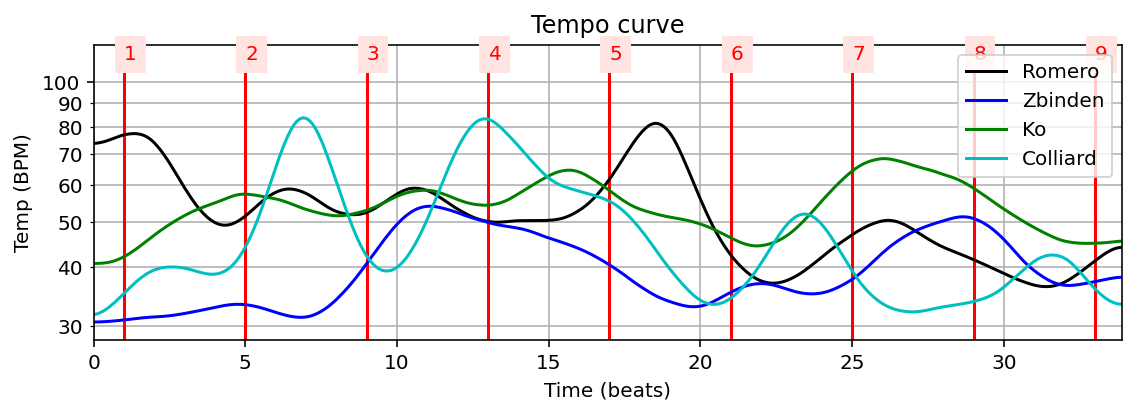

In [14]:
ylim = [28, 120]
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
plt.title('Dependency on performer')

para_dict = {}
para_dict[0] = ['Romero', 'k', 0,
                os.path.join('..', 'data', 'C3', 'FMP_C3S3_Schumann_Op15No7_Traeumerei_HernandezRomero.wav')]
para_dict[1] = ['Zbinden', 'b', 0,
                os.path.join('..', 'data', 'C3', 'FMP_C3S3_Schumann_Op15No7_Traeumerei_Zbinden.wav')]
para_dict[2] = ['Ko', 'g', 0,
                os.path.join('..', 'data', 'C3', 'FMP_C3S3_Schumann_Op15No7_Traeumerei_TimKo.wav')]
para_dict[3] = ['Colliard', 'c', -5,
                os.path.join('..', 'data', 'C3', 'FMP_C3S3_Schumann_Op15No7_Traeumerei_ColliardLigoratti.wav')]

for n in para_dict:
    performer, color, shift, fn_wav = para_dict[n]
    Fs = 22050
    x, Fs = librosa.load(fn_wav, Fs)
    win_len_beat = 6
    Fs_beat = 10
    f_tempo, t_beat = compute_tempo_curve(score, x, win_len_beat=win_len_beat, Fs_beat=Fs_beat)
    plot_tempo_curve(f_tempo, t_beat, ax=ax, color=color, label=performer,
                         logscale=True, ylim=ylim, measure_pos=measure_pos_beat)
ax.legend(loc='upper right')
plt.tight_layout()

<img src="../data/C3/FMP_C3_F24_score.png" width="700px" align="center" alt="C1">

<div>
<table>
   <tbody>
    <tr>
       <td style="border:none;text-align:left;"><font color="black">Romero  </font></td>
       <td style="border:none;text-align:left;"><font color="blue">Zbinden  </font></td>
       <td style="border:none;text-align:left;"><font color="green">Ko      </font></td>
       <td style="border:none;text-align:left;"><font color="cyan">Colliard</font></td>
   </tr>    
    
   <tr>
        <td style="border:none;text-align:left;">
            <audio style="width: 150px;" src="../data/C3/FMP_C3S3_Schumann_Op15No7_Traeumerei_HernandezRomero.mp3" type="audio/mpeg" controls="controls"></audio>
        </td>
        <td style="border:none;text-align:left;">
            <audio style="width: 150px;" src="../data/C3/FMP_C3S3_Schumann_Op15No7_Traeumerei_Zbinden.mp3" type="audio/mpeg" controls="controls"></audio>
        </td>       
        <td style="border:none;text-align:left;">
            <audio style="width: 150px;" src="../data/C3/FMP_C3S3_Schumann_Op15No7_Traeumerei_TimKo.mp3" type="audio/mpeg" controls="controls"></audio>
        </td>
        <td style="border:none;text-align:left;">
            <audio style="width: 150px;" src="../data/C3/FMP_C3S3_Schumann_Op15No7_Traeumerei_ColliardLigoratti.mp3" type="audio/mpeg" controls="controls"></audio>
        </td>
   </tr>  
        
</tbody></table>
</div>

## Further Notes

In this notebook, we discussed how to derive tempo curves from audio recordings using music synchronization techniques, where the actual performance is compared with some score-like reference representation of the underlying  musical piece. We have seen that the overall approach involves many design choices and parameter settings: 

* Feature representation (e.g., chroma features, feature resolution)
* Alignment procedure (e.g., DTW with specific parameter settings)
* Derivation of tempo information (e.g., differentiation, smoothing technique, filter length)
* Interpretation of tempo values (e.g., centered view, causal view, logarithmic axis)

Using a simple chroma-based DTW approach may lead to overall meaningful alignment results (on a coarse temporal level); however, local temporal inaccuracies and deviations may have a substantial impact on the resulting tempo curves. As a result, the above tempo curves of the four recordings may indicate overall tempo trends, but the results need to be handled with caution. For a detailed discussion on how the tempo curves depend on the size of the analysis window and on the presence of synchronization inaccuracies, we refer to the article <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2009_MuellerKonzScharfsteinEwertClausen_TempoCurves_ISMIR.pdf"><strong>Towards Automated Extraction of Tempo Parameters from Expressive Music Recordings</strong></a>. 

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and <a href="https://www.audiolabs-erlangen.de/fau/assistant/zalkow">Frank Zalkow</a>.
</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>